# 1: KNN Analysis

**Objective**: According to the dataset's text file, the target column is the
               last column in the dataset.

## 1.A Python Setup

In [1]:
import datetime
import itertools
import logging
import math
import matplotlib.pylab as plt
import matplotlib.pyplot
import numbers
import numpy as np
import operator
import pandas as pd
import scipy
import scipy.stats
import seaborn as sns
import sklearn.compose
import sklearn.ensemble
import sklearn.gaussian_process
import sklearn.metrics
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.neighbors
import sklearn.pipeline
import sklearn.svm
import statsmodels.api as sm
import typing
%matplotlib inline


pd.set_option('max_row', 100)

# Set up logging ... INFO for my code, WARNING for libraries
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.basicConfig(format='%(asctime)s - %(levelname)-6s - %(name)10s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO)

LOGGER = logging.getLogger('Week5')


def summary_graphs(df: pd.DataFrame, measurements, boxplot=True, hist=True, probplot=True, title_prefix=''):
    ''' Creates a figure with multiple plots for each requested measurement.

        Parameters
        ----------
        df: pd.DataFrame
            The source dataframe
        measurements: str | list
            One or more columns (measurements) to graph
        title_prefix: str (optional)
            A prefix to apply to each plot title

    '''
    measurements = measurements if type(measurements) is list else [measurements]
    num_measurements = len(measurements)
    figures_per_measurement = (1 if boxplot else 0) + (1 if hist else 0) + (1 if probplot else 0)
    figure_cols = figures_per_measurement
    figure_rows = int(math.ceil((num_measurements * figures_per_measurement) / figure_cols))

    # A personal figure size preference, based on the number or rows and cols:
    matplotlib.pyplot.figure(figsize=(4.0 * figure_cols, 4.0 * figure_rows))

    for i in range(num_measurements):
        column_name = measurements[i]
        column_values = df[column_name]

        if boxplot:
            matplotlib.pyplot.subplot(figure_rows,
                                      figure_cols,
                                      (i * figures_per_measurement) + 1,
                                      title=f'{title_prefix}{column_name} Boxplot')
            matplotlib.pyplot.boxplot(column_values)

        if hist:
            ax = matplotlib.pyplot.subplot(figure_rows,
                                           figure_cols,
                                           (i * figures_per_measurement) + 2,
                                           title=f'{title_prefix}{column_name} Histogram')
            sns.histplot(column_values, kde=True, ax=ax)
            matplotlib.pyplot.axvline(column_values.mean(), color='red')
            matplotlib.pyplot.axvline(column_values.median(), color='black', linestyle='dashed')

        if probplot:
            ax = matplotlib.pyplot.subplot(figure_rows,
                                           figure_cols,
                                           (i * figures_per_measurement) + 3,
                                           title=f'{title_prefix}{column_name} Probability')
            scipy.stats.probplot(column_values, plot=ax)

    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

def accuracy_recall_precision(predictions, truth):
    true_positives = np.sum(np.logical_and(predictions == 1, truth == 1))
    true_negatives = np.sum(np.logical_and(predictions == 0, truth == 0))
    false_positives = np.sum(np.logical_and(predictions == 1, truth == 0))
    false_negatives = np.sum(np.logical_and(predictions == 0, truth == 1))

    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    recall = true_positives / (true_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives)

    return (accuracy, recall, precision)

## 1.B Data Acquisition

### 1.B.1 Examine the data file

In [2]:
# Examine the file type
!file data/assign_wk5/bank-additional-full.csv

data/assign_wk5/bank-additional-full.csv: ASCII text, with CRLF line terminators


In [3]:
# How many lines?
!wc -l data/assign_wk5/bank-additional-full.csv

41189 data/assign_wk5/bank-additional-full.csv


### 1.B.2 Data file description

(from **`bank-additional-names.txt`**):

---

#### Input variables:

*Bank client data*:
 1. age (numeric)
 2. job    
    | A - E         | H - R         | S             | T - U         |
    |:--------------|:--------------|:--------------|:--------------|
    | admin.        | housemaid     | self-employed | technician    |
    | blue-collar   | management    | services      | unemployed    |
    | entrepreneur  | retired       | student       | unknown       |

 3. marital    
    |                       |           |           |           |
    |:----------------------|:----------|:----------|:----------|
    | divorced (or widowed) | married   | single    | unknown   |

 4. education    
    | Basic     | Higher                | Misc.         |
    |:----------|:----------------------|:--------------|
    | basic.4y  | high.school           | illiterate    |
    | basic.6y  | professional.course   | unknown       |
    | basic.9y  | university.degree     |               |

 5. default (has credit in default?)   
    no, yes, unknown
 6. housing (has housing loan?)   
    no, yes, unknown
 7. loan (has personal loan?)    
    no, yes, unknown

*Related with the last contact of the current campaign*:

 8. contact (contact communication type)    
    cellular, telephone
 9. month (last contact month of year)    
    jan, feb, mar, ..., nov, dec
10. day_of_week (last contact day of the week)    
    mon, tue, wed, thu, fri
11. duration    
    last contact duration, in seconds (numeric).    
    *Important note*:  this attribute highly affects the output target (e.g., if `duration=0` then `y="no"`). Yet, the duration is not known before a call is performed. Also, after the end of the call `y` is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

*Other attributes*:

12. campaign    
    number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays    
    number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous    
    number of contacts performed before this campaign and for this client (numeric)
15. poutcome (outcome of the previous marketing campaign)    
    failure, nonexistent, success

*Social and economic context attributes*:

16. emp.var.rate    
    employment variation rate - quarterly indicator (numeric)
17. cons.price.idx    
    consumer price index - monthly indicator (numeric)
18. cons.conf.idx    
    consumer confidence index - monthly indicator (numeric)
19. euribor3m (the interest rate at which a selection of European banks lend one another funds denominated in euros (I had to look this up))    
    euribor 3 month rate - daily indicator (numeric)
20. nr.employed    
    number of employees - quarterly indicator (numeric)

#### Output variable (desired target):

21. y (has the client subscribed a term deposit?)    
    yes, no

Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques.

---

In [4]:
# Load the file (separator is ';' vice ',')
bank_df = pd.read_csv('data/assign_wk5/bank-additional-full.csv', sep=';')

# Verify the loaded file (based on 'wc -l' above, we expect 41,188 lines)
bank_df.shape


(41188, 21)

In [5]:
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
# Per the description above, we don't expect null values
# (instead, the data set has 'unknown' entries)
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
bank_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


## 1.C Prepare the data for machine learning

### 1.C.1 Inspect numerical features

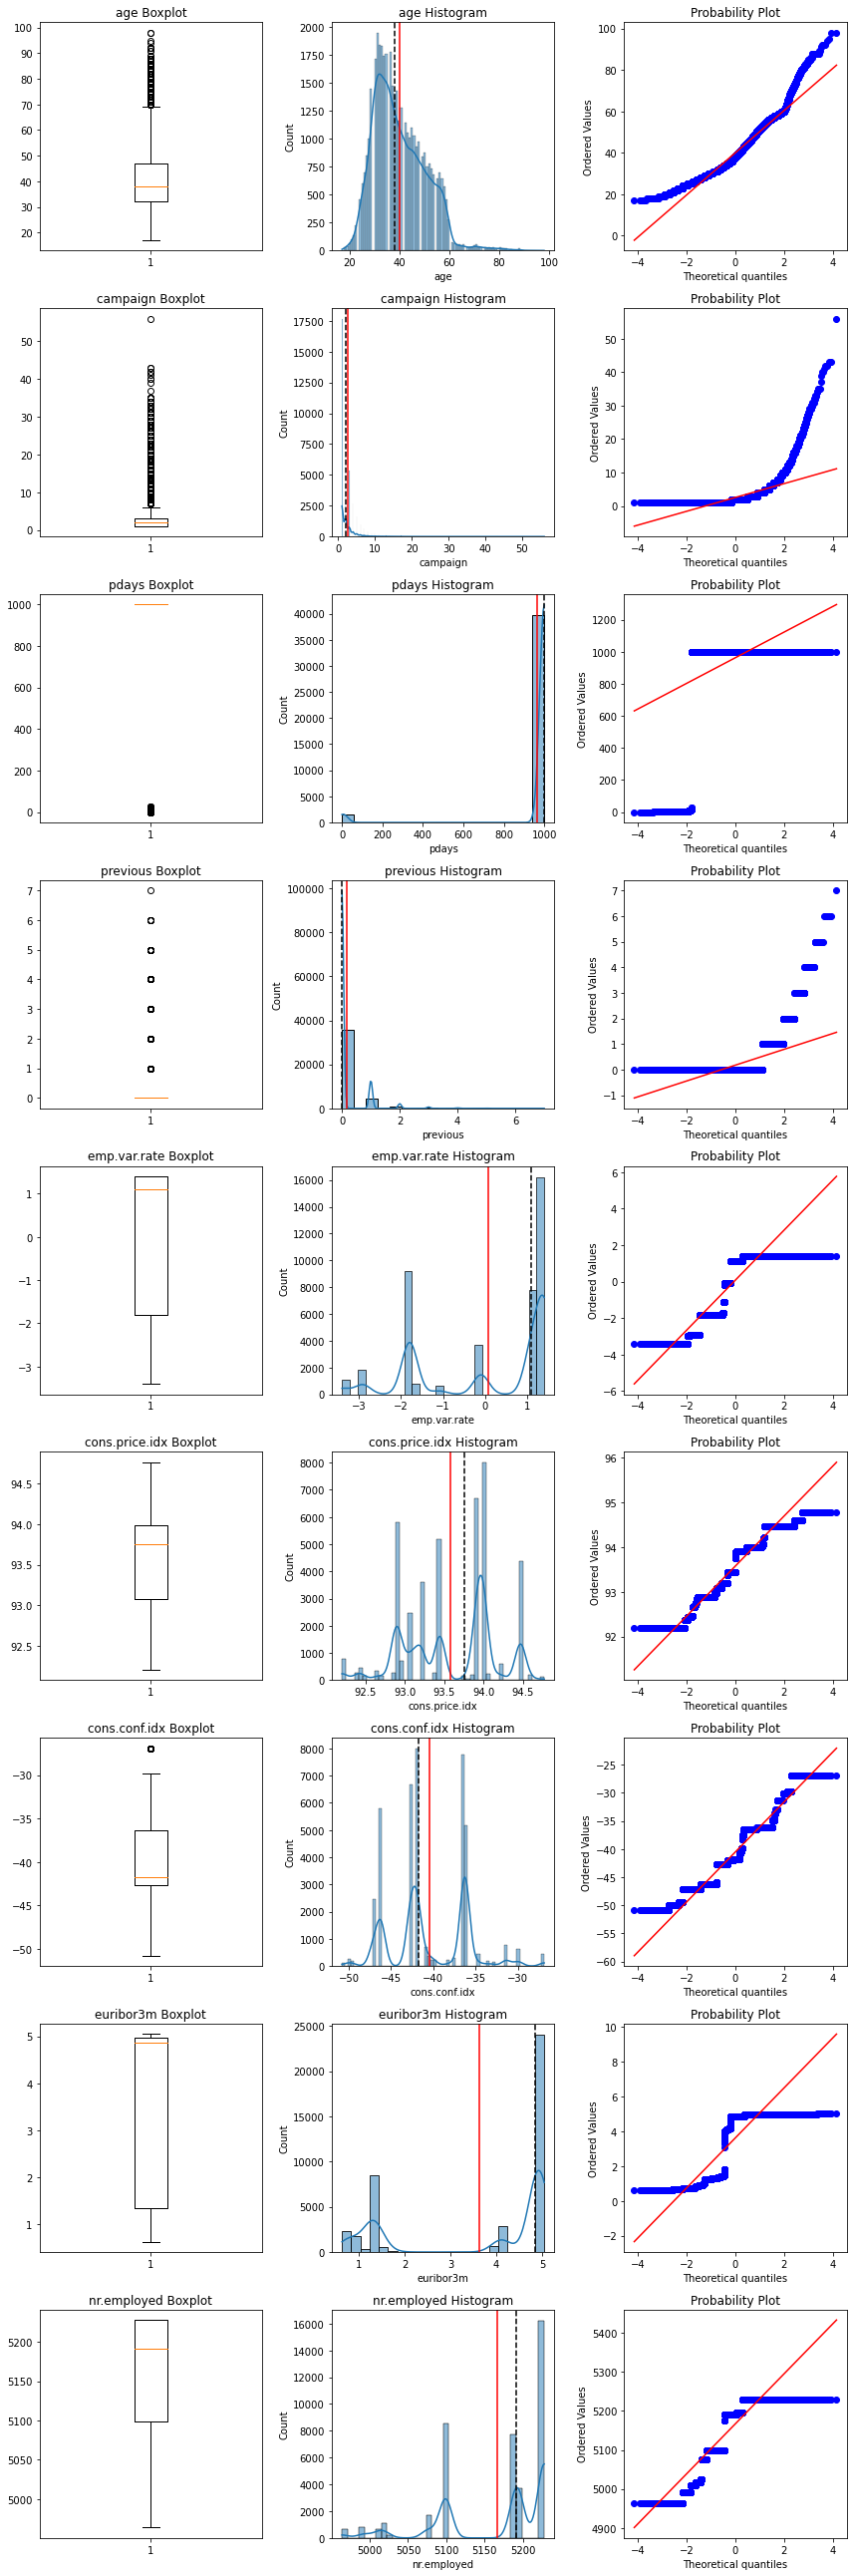

In [8]:
# Graph some values and visually inspect them for sanity:
summary_graphs(bank_df, ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'])

In [9]:
# age:              OK
# pdays:            I believe the use of 999 as 'not contacted' throws off the scale.
#                   I use StandardScaler below but the use of 999 was arbitrary (it could
#                   have been 99 or pi)
# previous:         OK
# emp.var.rate:     OK
# cons.price.idx:   OK
# cons.conf.idx:    OK
# Euribor 3-month:  OK
# nr.employed:      OK

bank_df['pdays_modified'] = bank_df.pdays.replace(to_replace=999.0, value=-1)

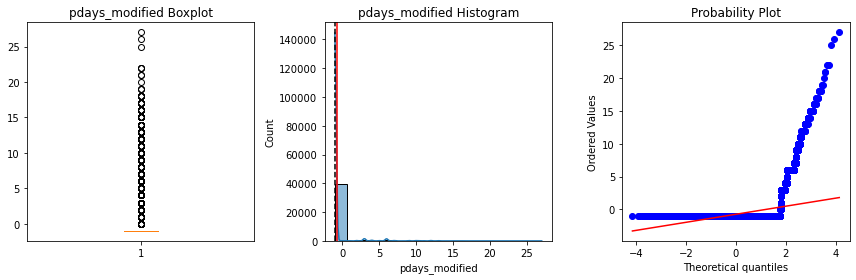

In [10]:
summary_graphs(bank_df, 'pdays_modified')

### 1.C.2 Inspect categorical features

In [11]:
CATEGORICAL = [
    'job',
    'marital',
    'education',
    'default',
    'housing',
    'loan',
    'contact',
    'month',
    'day_of_week',
    'poutcome',
    'y'
]
pd.DataFrame(bank_df[CATEGORICAL].melt(var_name='column', value_name='value').value_counts())   \
    .rename(columns={0: 'counts'})                                                              \
    .sort_values(by=['column', 'counts'], ascending=[True, False])

counts
column      value                      
contact     cellular              26144
            telephone             15044
day_of_week thu                    8623
            mon                    8514
            wed                    8134
            tue                    8090
            fri                    7827
default     no                    32588
            unknown                8597
            yes                       3
education   university.degree     12168
            high.school            9515
            basic.9y               6045
            professional.course    5243
            basic.4y               4176
            basic.6y               2292
            unknown                1731
            illiterate               18
housing     yes                   21576
            no                    18622
            unknown                 990
job         admin.                10422
            blue-collar            9254
            technician             6743
            services               3969
            management             2924
            retired                1720
            entrepreneur           1456
            self-employed          1421
            housemaid              1060
            unemployed             1014
            student                 875
            unknown                 330
loan        no                    33950
            yes                    6248
            unknown                 990
marital     married               24928
            single                11568
            divorced               4612
            unknown                  80
month       may                   13769
            jul                    7174
            aug                    6178
            jun                    5318
            nov                    4101
            apr                    2632
            oct                     718
            sep                     570
            mar                     546
            dec                     182
poutcome    nonexistent           35563
            failure                4252
            success                1373
y           no                    36548
            yes                    4640

### 1.C.3 Feature selection

In [12]:
# Per the description of the dataset, we shouldn't use 'duration' as a predictor since
# it could be considered a proxy for y
#
# Create a new DataFrame with only desired values
# NOTE: Not all values from the DataFrame will be used

# LabelEncoder is used to transform target values (not inputs)
y_encoder = sklearn.preprocessing.LabelEncoder().fit(bank_df.y)

SELECTED_CATEGORICAL = ['poutcome', 'default', 'loan']
SELECTED_NUMERICAL = ['campaign', 'pdays_modified', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

analysis_df = bank_df[[*SELECTED_CATEGORICAL, *SELECTED_NUMERICAL]]
analysis_df.describe().T


,count,mean,std,min,25%,50%,75%,max
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays_modified,41188.0,-0.741988,1.510327,-1.000,-1.000,-1.000,-1.000,27.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


### 1.C.4 Separate inputs from labels

In [13]:
X = analysis_df.values[:, :]
y = y_encoder.transform(bank_df.y)

### 1.C.5 Create train/test split

In [14]:
random_seed = 42
num_splits = 5

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=random_seed)
LOGGER.info(f'Train: X={str(X_train.shape)}, y={str(y_train.shape)}')
LOGGER.info(f'Test:  X={str(X_test.shape)},  y={str(y_test.shape)}')


2021-11-22 01:09:16 - INFO   -      Week5 - Train: X=(32950, 11), y=(32950,)
2021-11-22 01:09:16 - INFO   -      Week5 - Test:  X=(8238, 11),  y=(8238,)


## 1.D KNN Analysis

### 1.D.1 What is the objective of the analysis?
The data set contains information about bank customers as well as economic data.
The bank seeks to have customers sign up for a term deposit (certificate of
deposit).  I.e., the y-value from the data set contains a '1' for customers
which subscribed to a term deposit, '0' for customers that did not.  The objective
is to predict whether a customer will create a term deposit.

### 1.D.2 What is the optimal K?
The analysis of K-value begins below.

**NOTE**: This section includes some portions of Part 2 (e.g., one improvement
I looked into was the distance weighting mechanism of KNN, **`uniform`** or
inverse of **`distance`**).

In [15]:


best = {'name': 'N/A', 'accuracy': -999}
worst = {'name': 'N/A', 'accuracy': 999}

LOGGER.debug('+-----------------------------------+---------------------+---------------------------------+')
LOGGER.debug('|                                   |      Training       |              Test               |')
LOGGER.debug('| Pipeline Name                     | Accuracy |   Std    | Accuracy |  Recall  | Precision |')
LOGGER.debug('+-----------------------------------+---------------------+----------+----------+-----------+')

metrics = {
    'uniform': { 'training-accuracy': [], 'test-accuracy': [], 'test-recall':[], 'test-precision': [] },
    'distance': { 'training-accuracy': [], 'test-accuracy': [], 'test-recall':[], 'test-precision': [] }
}
knn_pipelines = []
for i in range(1, 50, 2):
    for w in ['uniform', 'distance']:
        name = f'scaled-encoded-knn-{i:02d}-{w}'
        pipeline = sklearn.pipeline.Pipeline([
            # A ColumnTransformer applies specific transforms to specific columns
            (f'ColumnTransformer-{i:02d}-{w}', sklearn.compose.ColumnTransformer(transformers=[
                # In this case, we want to apply StandardScaler only to numerical columns:
                (f'StandardScaler-{i:02d}-{w}',
                    sklearn.preprocessing.StandardScaler(),
                    [analysis_df.columns.tolist().index(x) for x in SELECTED_NUMERICAL]),

                # We want to apply OneHotEncoder to categorical columns:
                (f'OneHotEncoder-{i:02d}-{w}',
                    sklearn.preprocessing.OneHotEncoder(),
                    [analysis_df.columns.tolist().index(x) for x in SELECTED_CATEGORICAL])],
                
                remainder='passthrough')),

            # KNN Classifier
            (f'knn-classifier-{i:02d}-{w}', sklearn.neighbors.KNeighborsClassifier(n_neighbors=i, weights=w))
        ])

        knn_pipelines.append((name, pipeline))

        kfold = sklearn.model_selection.KFold(n_splits=num_splits, random_state=random_seed, shuffle=True)

        result = sklearn.model_selection.cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score))

        mean = result.mean()
        std = result.std()

        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test)

        accuracy, recall, precision = accuracy_recall_precision(predictions, y_test)

        LOGGER.debug(f'| {name: <33s} | {mean:>8.04%} | {std:>8.04f} | {accuracy:>8.04%} | {recall:>8.04%} |  {precision:>8.04%} |')
        LOGGER.debug('+-----------------------------------+---------------------+----------+----------+-----------+')

        metrics[w]['training-accuracy'].append(mean)
        metrics[w]['test-accuracy'].append(accuracy)
        metrics[w]['test-recall'].append(recall)
        metrics[w]['test-precision'].append(precision)

        if accuracy > best['accuracy']:
            best = {
                'name': name,
                'accuracy': accuracy,
                'recall': recall,
                'precision': precision,
                'predictions': predictions,
                'pipeline': pipeline,
                'raw': result
            }

        if accuracy < worst['accuracy']:
            worst = {
                'name': name,
                'accuracy': accuracy,
                'recall': recall,
                'precision': precision,
                'predictions': predictions,
                'pipeline': pipeline,
                'raw': result
            }

LOGGER.info('Best:  {name} {accuracy:.04%} (recall: {recall:.04%}, precision: {precision:.04%})'.format(name=best['name'],
                                                                                                        accuracy=best['accuracy'],
                                                                                                        recall=best['recall'],
                                                                                                        precision=best['precision']))
LOGGER.info('Worst: {name} {accuracy:.04%} (recall: {recall:.04%}, precision: {precision:.04%})'.format(name=worst['name'],
                                                                                                        accuracy=worst['accuracy'],
                                                                                                        recall=worst['recall'],
                                                                                                        precision=worst['precision']))


2021-11-22 01:30:20 - INFO   -      Week5 - Best:  scaled-encoded-knn-33-uniform 89.5970% (recall: 24.7059%, precision: 60.1562%)
2021-11-22 01:30:20 - INFO   -      Week5 - Worst: scaled-encoded-knn-01-uniform 85.4819% (recall: 31.2299%, precision: 34.5562%)


### 1.D.2 (cont'd) What is the optimal K?
The optimal K value, measured by accuracy, is **`33`**.

### 1.D.3 How about accuracy rate?
A K value of **`33`** produces a `89.6%` accuracy rate against the *test data*.  However, the precision is much
lower at `60.2%` and recall is even worse at `24.7%`.

* accuracy: ratio of correct predictions to all predictions    
  $ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} $
* precision: ratio of true positives to true and false positives    
  $ Precision = \frac{TP}{TP + FP} $
* recall: ratio of true positives to true positives and false negatives    
  $ Recall = \frac{TP}{TP + FN} $


### 1.D.4 Include graphs to support conclusions
Below, I graph accuracy, recall, and precision against different values of K
in support of the following conclusions:

* Training and test accuracy closely track each other for most values of K
* Precision varies for low values of K then genarlly stabilizes
* Recall worsens over time due to an increase in false-negatives


2021-11-22 01:30:20 - INFO   -      Week5 - KNN weight strategy: distance Best training-accuracy... 89.1866% with k=49
2021-11-22 01:30:20 - INFO   -      Week5 - KNN weight strategy: distance Best test-accuracy....... 89.2328% with k=21
2021-11-22 01:30:20 - INFO   -      Week5 - KNN weight strategy: distance Best test-recall......... 31.2299% with k=1
2021-11-22 01:30:20 - INFO   -      Week5 - KNN weight strategy: distance Best test-precision...... 55.2632% with k=21
2021-11-22 01:30:20 - INFO   -      Week5 - KNN weight strategy: uniform  Best training-accuracy... 90.0000% with k=37
2021-11-22 01:30:20 - INFO   -      Week5 - KNN weight strategy: uniform  Best test-accuracy....... 89.5970% with k=33
2021-11-22 01:30:20 - INFO   -      Week5 - KNN weight strategy: uniform  Best test-recall......... 31.2299% with k=1
2021-11-22 01:30:20 - INFO   -      Week5 - KNN weight strategy: uniform  Best test-precision...... 60.6838% with k=47


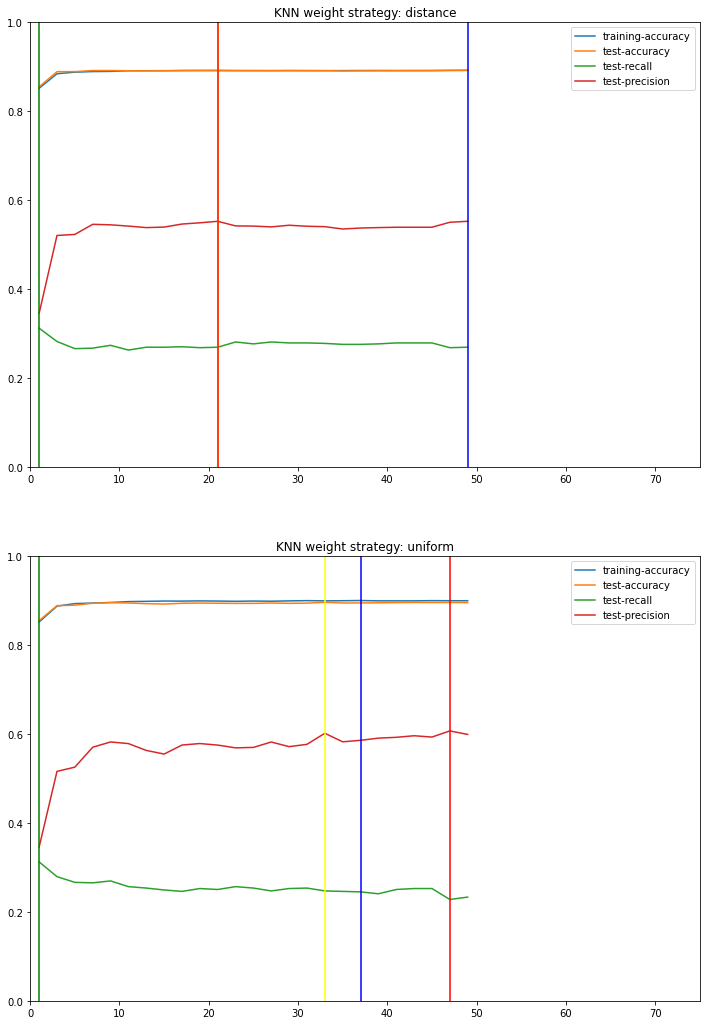

In [16]:
plot_metrics = ['training-accuracy', 'test-accuracy', 'test-recall', 'test-precision']
metric_colors = ['blue', 'yellow', 'green', 'red']

figure_cols=1
figure_rows=2

matplotlib.pyplot.figure(figsize=(12 * figure_cols, 9 * figure_rows))

for figure_index, weight in enumerate(['distance', 'uniform']):
    y_values = []

    for i in range(len(range(1, 50, 2))):
        _y = []
        for metric in plot_metrics:
            _y.append(metrics[weight][metric][i])
        y_values.append(_y)

    matplotlib.pyplot.subplot(figure_rows, figure_cols, figure_index + 1, title=f'KNN weight strategy: {weight}')
    matplotlib.pyplot.plot(range(1, 50, 2), y_values, label=plot_metrics)
    matplotlib.pyplot.legend()
    matplotlib.pyplot.ylim([0, 1.0])
    matplotlib.pyplot.xlim([0, 75])

    for index, metric in enumerate(plot_metrics):
        x, max_y = max(enumerate(metrics[weight][metric]), key=operator.itemgetter(1))
        x = (x * 2) + 1
        LOGGER.info(f'KNN weight strategy: {weight: <8} Best {metric:.<20} {max_y:0.4%} with k={x}')
        matplotlib.pyplot.axvline(x, color=metric_colors[index])


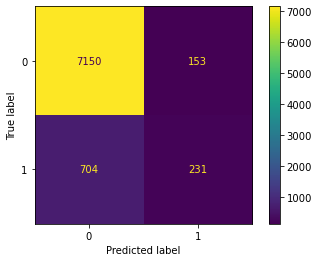

In [17]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, best['predictions'])
plt.show()

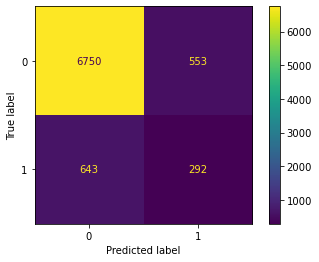

In [18]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, worst['predictions'])
plt.show()


### 1.D.5 Discuss ways to improve the performance of the KNN model

**KNeighborsClassifier weight function**    
The first graph above utilizes an inversely proportional weight for the K nearest neighbors.

The second graph above utilizes a uniform weight for neighbors and 
performs slightly better than the proportional weight.

**Feature selection**    
I went thru many combinations of features and examined relationships between
each feature and the y-value.  I removed the correlation plot(s) when I moved the
scaling and one-hot encoding to be part of the pipeline (this is a lesson
learned... I'd like more visibility into those transformations and their
effect on the data).  Anyway, it's also possible that I missed a feature with
high correlation to y (my understanding is that one of the libraries has
a feature selection capability, but I did not get a chance to investigate
that).

Features I tried but rejected (no correlation):
* housing
* education
* marital

# 2 Comparison to others supervised algorithms

## 2.1 Implement one of the methods to improve the performance of the KNN model
As mentioned in 1.D.2, I built in a mechanism to compare the KNeighborsClassifier
weight function (uniform vs distance).  In this case, the uniform weighted
predictor performed slightly better.

## 2.2 Perform a K-fold cross-validation analysis

I chose the following additional classifer models:
* RandomForestClassifier
* GaussianNaiveBayes
* AdaBoostClassifier
* LinearSVC


In [19]:

LOGGER.debug('+-----------------------------------+---------------------+---------------------------------+')
LOGGER.debug('|                                   |      Training       |              Test               |')
LOGGER.debug('| Pipeline Name                     | Accuracy |   Std    | Accuracy |  Recall  | Precision |')
LOGGER.debug('+-----------------------------------+---------------------+----------+----------+-----------+')

metrics = { }

models = [
    ('RandomForestClassifier', sklearn.ensemble.RandomForestClassifier(n_estimators=len(analysis_df.columns)**2, random_state=random_seed)),

    ('GaussianNaiveBayes', sklearn.naive_bayes.GaussianNB()),

    ('AdaBoostClassifier', sklearn.ensemble.AdaBoostClassifier()),

    # Originally chose sklearn.svm.SVC.  But, per scikit-learn.org the fit time scales at least quadratically
    # with the number of samples and may be impractical beyond tens of thousands of samples...
    # sklearn.svm.SVC(kernel='linear', C=0.025)
    #
    # So, switching to at true linear regression classifier:
    ('LinearSVC', sklearn.svm.LinearSVC(C=0.025, random_state=random_seed))
]
model_pipelines = []

for name, model in models:
    pipeline = sklearn.pipeline.Pipeline([
        # A ColumnTransformer applies specific transforms to specific columns
        (f'ColumnTransformer', sklearn.compose.ColumnTransformer(transformers=[
            # In this case, we want to apply StandardScaler only to numerical columns:
            (f'StandardScaler',
                sklearn.preprocessing.StandardScaler(),
                [analysis_df.columns.tolist().index(x) for x in SELECTED_NUMERICAL]),

            # We want to apply OneHotEncoder to categorical columns:
            (f'OneHotEncoder',
                sklearn.preprocessing.OneHotEncoder(),
                [analysis_df.columns.tolist().index(x) for x in SELECTED_CATEGORICAL])],
            
            remainder='passthrough')),

        # Classifier xyz
        (name, model)
    ])

    model_pipelines.append((name, pipeline))

    kfold = sklearn.model_selection.KFold(n_splits=num_splits, random_state=random_seed, shuffle=True)

    result = sklearn.model_selection.cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score))

    mean = result.mean()
    std = result.std()

    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)

    accuracy, recall, precision = accuracy_recall_precision(predictions, y_test)

    LOGGER.debug(f'| {name: <33s} | {mean:>8.04%} | {std:>8.04f} | {accuracy:>8.04%} | {recall:>8.04%} |  {precision:>8.04%} |')
    LOGGER.debug('+-----------------------------------+---------------------+----------+----------+-----------+')

    metrics[name] = {
        'training-accuracy': mean,
        'test-accuracy': accuracy,
        'test-recall': recall,
        'test-precision': precision
    }
    
    if accuracy > best['accuracy']:
        best = {
            'name': name,
            'accuracy': accuracy,
            'recall': recall,
            'precision': precision,
            'predictions': predictions,
            'pipeline': pipeline,
            'raw': result
        }

    if accuracy < worst['accuracy']:
        worst = {
            'name': name,
            'accuracy': accuracy,
            'recall': recall,
            'precision': precision,
            'predictions': predictions,
            'pipeline': pipeline,
            'raw': result
        }

LOGGER.info('Best:  {name} {accuracy:.04%} (recall: {recall:.04%}, precision: {precision:.04%})'.format(name=best['name'],
                                                                                                        accuracy=best['accuracy'],
                                                                                                        recall=best['recall'],
                                                                                                        precision=best['precision']))
LOGGER.info('Worst: {name} {accuracy:.04%} (recall: {recall:.04%}, precision: {precision:.04%})'.format(name=worst['name'],
                                                                                                        accuracy=worst['accuracy'],
                                                                                                        recall=worst['recall'],
                                                                                                        precision=worst['precision']))


2021-11-22 01:31:14 - INFO   -      Week5 - Best:  AdaBoostClassifier 89.8155% (recall: 20.0000%, precision: 67.2662%)
2021-11-22 01:31:14 - INFO   -      Week5 - Worst: GaussianNaiveBayes 72.7482% (recall: 68.8770%, precision: 24.7883%)


## 2.3 Discuss the difference in the performance

Recall that the best KNeighborClassification (k=33, weight=uniform) achieved 89.5970% accuracy (recall: 24.7059%, precision: 60.1562%)

The AdaBoostClassifier achived very slightly higher accuracy (89.8% compared to 89.6%) but significantly higher precision (67.3% to 60.2%).
Still, I cannot seem to improve recall and precision simultaneously (both KNN and AdaBoostClassifer achieved less than 25% recall).

Interestingly, the GaussianNaiveBayes classifier achieved 68.9% recall!  Unfortunately, it scored very poorly on precision.
